In [1]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from skimage.measure import marching_cubes
import ipywidgets as widgets
from ipywidgets import interactive
%matplotlib widget


In [2]:
a = 1.0
b = 1.0
c = 1.0
n_x = 0
n_y = 0
n_z = 0

# Read the data from the file
data = []
atoms = []
species_list = []
species_name_list = []
with open('../viability_BTO.dat', 'r') as file:
    for line in file:
        # if line starts with #grid, read the three values as n_x, n_y, n_z
        if line.startswith("#grid"):
            values = line.strip().split()
            n_x = int(values[1])
            n_y = int(values[2])
            n_z = int(values[3])
        # if line starts with #lat, read the three values as a, b, c
        if line.startswith("#lat"):
            values = line.strip().split()
            a = float(values[1])
            b = float(values[2])
            c = float(values[3])
        if line.startswith("#species"):
            values = line.strip().split()
            species_name_list = values[1:]
        if line.startswith("#"):
            continue
        values = line.strip().split()
        if len(values) == 3:
            atoms.append([float(values[0]), float(values[1]), float(values[2])])
        if len(values) >= 4:
            data.append([float(values[0]), float(values[1]), float(values[2]), float(values[3])])
            if len(values) > 4:
                species_list.append(int(values[4]))

# scale atom locations
atoms = np.array(atoms)
atoms[:,0] = atoms[:,0] * a
atoms[:,1] = atoms[:,1] * b
atoms[:,2] = atoms[:,2] * c

# set the min and max values for the grid
x_min = a * ( 0.0 )
x_max = a * ( 1.0 - 1.0/n_x )
y_min = b * ( 0.0 )
y_max = b * ( 1.0 - 1.0/n_y )
z_min = c * ( 0.0 )
z_max = c * ( 1.0 - 1.0/n_z )

# Create a 3D grid
grid_x, grid_y, grid_z = np.mgrid[x_min:x_max:complex(n_x), y_min:y_max:complex(n_y), z_min:z_max:complex(n_z)]
grid_points = np.vstack((grid_x.ravel(), grid_y.ravel(), grid_z.ravel())).T



In [3]:
grid_values = []
distance_threshold = 1e-3
for spec in sorted(set(species_list)):
    # Extract the coordinates and values
    x = np.array([row[0] for row, species in zip(data,species_list) if species == spec])
    y = np.array([row[1] for row, species in zip(data,species_list) if species == spec])
    z = np.array([row[2] for row, species in zip(data,species_list) if species == spec])
    values = np.array([row[3] for row, species in zip(data,species_list) if species == spec])

    # scale the data positions
    x = x * a
    y = y * b
    z = z * c

    # Calculate distances to the nearest known data point
    tree = cKDTree(np.c_[x, y, z])
    distances, _ = tree.query(grid_points, k=1)

    # Interpolate data onto the 3D grid
    grid_values.append(griddata((x, y, z), values, (grid_x, grid_y, grid_z), method='nearest', fill_value=0.0))
    # grid_values[spec] = np.nan_to_num(grid_values)
    grid_values[spec-1] = grid_values[spec-1] / np.max(grid_values[spec-1])

    # Reshape distances to match the grid shape
    distances = distances.reshape(grid_values[spec-1].shape)

    # Set threshold for distance (e.g., 1 unit)
    grid_values[spec-1][distances > distance_threshold] = 0  # Set to zero for points beyond the threshold


In [4]:
# Function to plot atoms as spheres
def plot_atoms_as_spheres(ax, atoms, radius=0.5, resolution=(10, 5)):
    u = np.linspace(0, 2 * np.pi, resolution[0])
    v = np.linspace(0, np.pi, resolution[1])
    for atom in atoms:
        atom_x, atom_y, atom_z = atom
        # Generate sphere coordinates
        x_sphere = atom_x + radius * np.outer(np.cos(u), np.sin(v))
        y_sphere = atom_y + radius * np.outer(np.sin(u), np.sin(v))
        z_sphere = atom_z + radius * np.outer(np.ones(np.size(u)), np.cos(v))
        # Plot spheres with lower resolution
        ax.plot_surface(x_sphere, y_sphere, z_sphere, color='red', alpha=1.0, rstride=1, cstride=1)
        
def plot_atoms_as_scatter(ax, atoms, size=100, color='red'):
    ax.scatter(atoms[:,0], atoms[:,1], atoms[:,2], s=size, c=color, alpha=1.0)


In [5]:
# Define a function to update the plot based on the isosurface level
def plot_isosurface(iso_level, species):
    # Clear current plot
    ax.cla()
    
    # Extract the isosurface
    verts, faces, normals, _ = marching_cubes(grid_values[species-1], level=iso_level, spacing=((x_max-x_min)/n_x, (y_max-y_min)/n_y, (z_max-z_min)/n_z))
    
    # Plot the isosurface using Poly3DCollection for interactivity
    mesh = Poly3DCollection(verts[faces])
    mesh.set_alpha(0.5)
    mesh.set_facecolor('blue')
    mesh.set_edgecolor('none')
    # mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    
    # Plot atoms as spheres
    # plot_atoms_as_spheres(ax, atoms)
    plot_atoms_as_scatter(ax, atoms, 200, 'red')
    
    # Set axis limits between 0 and 1 and labels
    ax.set_xlim([0, a])
    ax.set_ylim([0, b])
    ax.set_zlim([0, c])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(0, 30)
    plt.draw()

In [6]:

# Set up the interactive slider widget
max_val = np.max(grid_values)
iso_slider = widgets.FloatSlider(value=0.05 * max_val, min=0, max=max_val, step=0.01 * max_val, description='Isosurface Level:');
species_selector = widgets.Dropdown(options=sorted(set(species_list)), description='Species:')


interactive(children=(FloatSlider(value=0.05, description='Isosurface Level:', max=1.0, step=0.01), Dropdown(d…

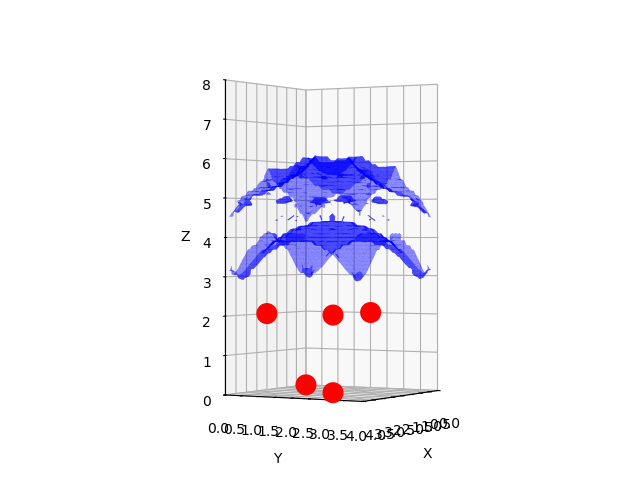

In [7]:
# Create the figure and axis
fig = plt.figure();
ax = fig.add_subplot(111, projection='3d');

# Set the aspect ratio based on the lattice parameters
ax.set_box_aspect([a, b, c])  # This scales the plot according to lattice ratios

# Display the interactive plot with the slider
interactive_plot = interactive(plot_isosurface, iso_level=iso_slider, species=species_selector);
output = interactive_plot.children[-1];
# output.layout.height = '400px';
interactive_plot